In [2]:
import sys
import os
sys.path.append(os.path.abspath('../src'))

import pandas as pd
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns
from data_loader import load_and_process_data

plt.style.use('bmh')
%matplotlib inline

# Load Data (2010 - Present)
df = load_and_process_data('../data/BrentOilPrices.csv', start_date='2010-01-01')
prices = df['Price'].values
n_samples = len(prices)
days = np.arange(n_samples)

print(f"Data Loaded: {n_samples} days")

2026-02-11 22:15:27,717 - INFO - Loading data from ../data/BrentOilPrices.csv...
2026-02-11 22:15:27,724 - INFO - Parsing mixed date formats...
2026-02-11 22:15:27,998 - INFO - Data filtered: 9011 -> 3260 rows (Post-2010-01-01).


Data Loaded: 3260 days


In [3]:
print("Building 2-Change-Point Model...")

with pm.Model() as model_multi:
    # --- PRIORS ---
    # We expect 3 regimes (High -> Low -> Recovery)
    # Means for the 3 regimes
    mu = pm.Normal('mu', mu=[100, 50, 90], sigma=20, shape=3)
    
    # Noise (assume constant for simplicity, or use shape=3 for variable volatility)
    sigma = pm.HalfNormal('sigma', sigma=10)
    
    # --- CHANGE POINTS (TAU) ---
    # We need 2 change points. 
    # To ensure tau1 < tau2, we can sample specific intervals or sort them.
    # Here we define the probability of change occurring at any day.
    
    # Prior for the first change point (somewhere in the first 60% of data)
    tau1 = pm.DiscreteUniform('tau1', lower=0, upper=n_samples//2)
    
    # Prior for the second change point (somewhere after tau1)
    tau2 = pm.DiscreteUniform('tau2', lower=tau1 + 1, upper=n_samples - 1)
    
    # --- LIKELIHOOD ---
    # Logic: 
    # If day < tau1: Regime 1
    # If tau1 <= day < tau2: Regime 2
    # If day >= tau2: Regime 3
    
    idx = np.arange(n_samples)
    mean_val = pm.math.switch(idx < tau1, mu[0], 
                              pm.math.switch(idx < tau2, mu[1], mu[2]))
    
    likelihood = pm.Normal('likelihood', mu=mean_val, sigma=sigma, observed=prices)

print("Model built.")

Building 2-Change-Point Model...
Model built.


In [4]:
with model_multi:
    # We increase tune/draws slightly for better convergence on complex models
    trace_multi = pm.sample(draws=2000, tune=1000, chains=2, target_accept=0.9, random_seed=42)

Multiprocess sampling (2 chains in 2 jobs)
2026-02-11 22:16:01,046 - INFO - Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
2026-02-11 22:16:01,048 - INFO - CompoundStep
>NUTS: [mu, sigma]
2026-02-11 22:16:01,049 - INFO - >NUTS: [mu, sigma]
>CompoundStep
2026-02-11 22:16:01,049 - INFO - >CompoundStep
>>Metropolis: [tau1]
2026-02-11 22:16:01,050 - INFO - >>Metropolis: [tau1]
>>Metropolis: [tau2]
2026-02-11 22:16:01,050 - INFO - >>Metropolis: [tau2]


Output()

Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 12 seconds.
2026-02-11 22:16:12,837 - INFO - Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 12 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
2026-02-11 22:16:13,118 - INFO - We recommend running at least 4 chains for robust computation of convergence diagnostics


Detected Change Point 1: 2014-11-25
Detected Change Point 2: 2017-10-25


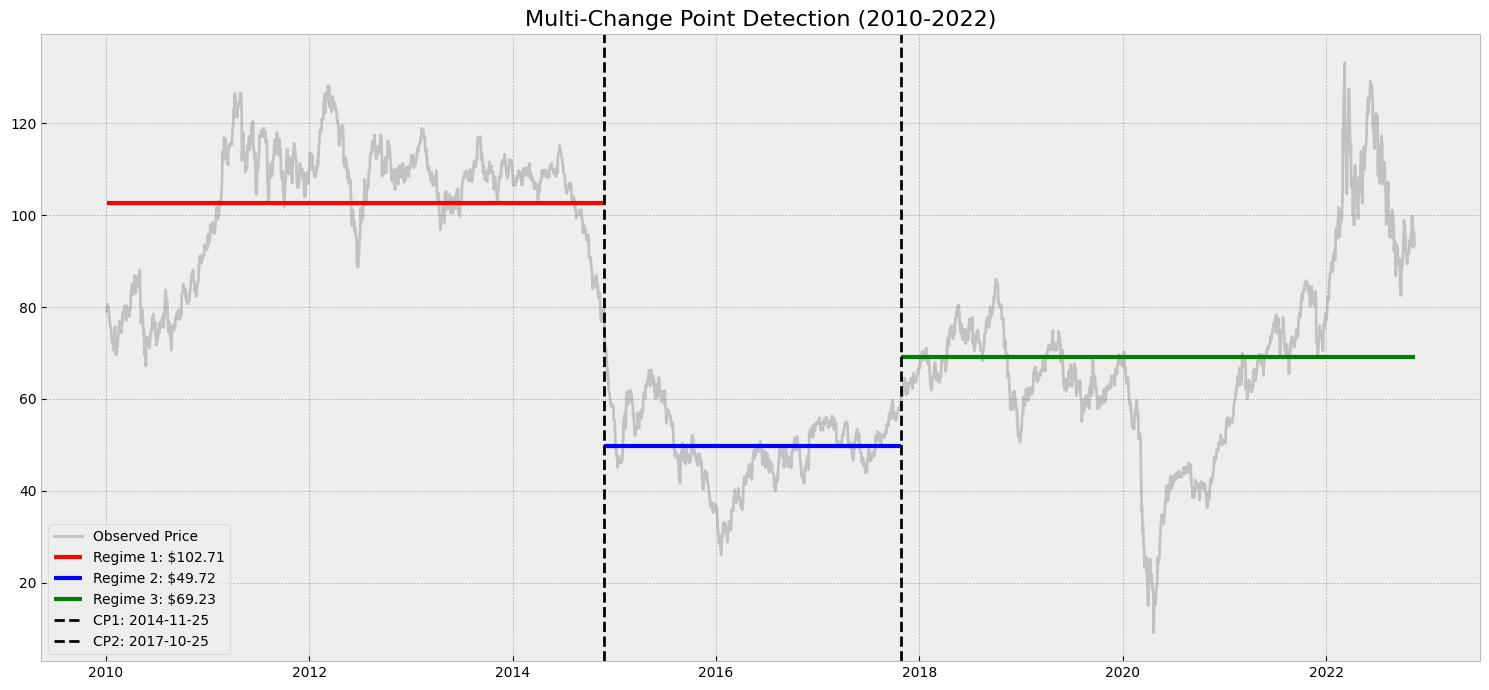

In [5]:
# Extract posteriors
tau1_mean = int(trace_multi.posterior['tau1'].mean())
tau2_mean = int(trace_multi.posterior['tau2'].mean())

date1 = df.iloc[tau1_mean]['Date'].date()
date2 = df.iloc[tau2_mean]['Date'].date()

print(f"Detected Change Point 1: {date1}")
print(f"Detected Change Point 2: {date2}")

# Plot
plt.figure(figsize=(15, 7))
plt.plot(df['Date'], df['Price'], color='grey', alpha=0.4, label='Observed Price')

# Get means
mus = trace_multi.posterior['mu'].mean(dim=["chain", "draw"]).values

# Plot Regimes
plt.hlines(mus[0], df['Date'].iloc[0], df.iloc[tau1_mean]['Date'], colors='r', lw=3, label=f'Regime 1: ${mus[0]:.2f}')
plt.hlines(mus[1], df.iloc[tau1_mean]['Date'], df.iloc[tau2_mean]['Date'], colors='b', lw=3, label=f'Regime 2: ${mus[1]:.2f}')
plt.hlines(mus[2], df.iloc[tau2_mean]['Date'], df['Date'].iloc[-1], colors='g', lw=3, label=f'Regime 3: ${mus[2]:.2f}')

plt.axvline(df.iloc[tau1_mean]['Date'], color='k', ls='--', label=f'CP1: {date1}')
plt.axvline(df.iloc[tau2_mean]['Date'], color='k', ls='--', label=f'CP2: {date2}')

plt.title('Multi-Change Point Detection (2010-2022)', fontsize=16)
plt.legend()
plt.tight_layout()
plt.savefig('../outputs/04_multi_changepoint.png')
plt.show()

In [6]:
# Create a clean summary CSV for the dashboard
dashboard_data = df.copy()
dashboard_data['Regime'] = 1
dashboard_data.loc[tau1_mean:tau2_mean, 'Regime'] = 2
dashboard_data.loc[tau2_mean:, 'Regime'] = 3

# Add the mean price for that regime
dashboard_data['Regime_Mean'] = dashboard_data['Regime'].map({1: mus[0], 2: mus[1], 3: mus[2]})

# Save to data folder
dashboard_data.to_csv('../data/processed_dashboard_data.csv', index=False)
print("Dashboard data saved to ../data/processed_dashboard_data.csv")

Dashboard data saved to ../data/processed_dashboard_data.csv
